# Introduction
The purpose of this workbook is to walkthrough the methods and approach I used to improve the ROI from 0 to 2 for marketing campaigns.  

Whilst the exact details cannot be shared, I demonstrate the challenges and how I overcame them with mocked data.

In [1]:
from jupyterthemes import get_themes
import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme
set_nb_theme("onedork")

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

## Background
Whilst working for a multi national telecom company, I was supporting the marketing department to find ways to enhance their marketing.  

The company often contacted their 3.5 million customers via Direct mail with offers to extend or upgrade their products.  

Marketing mix models had suggested that this was not providing return and therefore we needed to understand how we could optimise this.

### Size of the Opportunity
There were numerous rules that existed for determing who was contacted and why.

There were around 1 million customers available to be targeted.  

However if a customer was contacted in the prior month, they were blocked from being contacted again.  

This meant about 500k mails were sent each month (including new business acquisition).  
Each mail cost roughly €1.

In [2]:
# size of opportunity calc
monthly_mail = 500000
cost_per = 1
annual_invest = monthly_mail * cost_per * 12

# the total budget was around €6m
print(f"Annual Budget to optimise was €{annual_invest/1000000}m")

Annual Budget to optimise was €6.0m


### Calcuating ROI
Until this point, the company had measured success based on the number of contracts sold.  
It was therefore not possible to calculate a ROI, or highlight which campaigns were working better than others.  

Therefore, the first task was to create a return calculation.  

The contracts were 24 months long.  Therefore, an average monthly price was calculated and attached to each campaign.  

### Stakeholder Resistance

There had been significant resistance to removing customers from the target group as there were high sales targets.  

However, this very simple approach demonstrated the need for a more data driven approach as there were campaigns which were very negative, and overall the performance of the department was neutral.  


In [33]:
#Then show that some campaigns were negative vs their costs  
# Literally summarise the campaigns and show the values
camp1 = 10000
uplift1 = 0.1
uplift_rev1 = 5
total_additional_rev1 = camp1 * uplift1 * uplift_rev1

cost_for_camp1 = camp1 * cost_per

print("Summary of Example Campaign where:")
print("{0:,} customers were contacted".format(camp1))
print("A {0:.0%} uplift was seen, and those customers now generate {1}€ more revenue".format(uplift1, uplift_rev1))
print()
print("This generates {0:,}€ return from this campaign".format(int(total_additional_rev1)))
print()
print("The cost of this campaign however was {0:,}€, meaning an overall loss of {1:,}€".format(cost_for_camp1,int(cost_for_camp1 - total_additional_rev1)))
print("This gives a ROI of {0:.1f}".format(total_additional_rev1 / cost_for_camp1))

Summary of Example Campaign where:
10,000 customers were contacted
A 10% uplift was seen, and those customers now generate 5€ more revenue

This generates 5,000€ return from this campaign

The cost of this campaign however was 10,000€, meaning an overall loss of 5,000€
This gives a ROI of 0.5


### Starting with Test & Learn with Control Groups

To increase the value, control groups were implemented.  
These groups would have been made an offer, but were withheld.  
These control groups still had some conversion via noise and prior contact, and it was expected that the treatment (offer) would have a positive impact.  

One sided proportional Z tests were used to evaluate if the uplift of the treatment was significant.  

Given the aggressive sales targets, the control groups were not of equal size to the treatment group.  

In [108]:
def eval_campaigns(n_total, treat_prop, baseline_rate, treat_conversion_rate, display = False, uplift_rev = 0):
    # -------------------------------
    # ⚙️ PARAMETERS — adjust as needed
    # -------------------------------

    n_treat = n_total * treat_prop # Total users in treatment group
    n_control = n_total - n_treat
    uplift = treat_conversion_rate - baseline_rate

    # Seed for reproducibility
    np.random.seed(42)

    # -------------------------------
    # 🔢 1. Simulate treatment group
    # -------------------------------

    # Simulate whether each user converts (1) or not (0)
    conversions = np.random.binomial(1, treat_conversion_rate, size=int(n_treat))

    # Wrap into a DataFrame
    df = pd.DataFrame({
        'user_id': np.arange(n_treat),
        'converted': conversions
    })

    # -------------------------------
    # 📊 2. Calculate overall conversion rate & significance
    # -------------------------------

    # Z-test for difference in proportions
    pooled_p = (treat_conversion_rate *  n_treat + n_control * baseline_rate) / (n_total)
    se = np.sqrt(pooled_p * (1 - pooled_p) * (1 / n_treat + 1 / n_control  ))
    z = (treat_conversion_rate - baseline_rate) / se
    p_value = 1 - norm.sf(z)  # One-sided test
    
    # -------------------------------
    # 📊 3. Calculate Return On Value
    # -------------------------------
    
    camp_cost = n_treat * 1
    uplift_rev_gen = uplift_rev * n_treat * uplift * 24 

    print(f"--- OVERALL TEST ---")
    if p_value > 0.95:
        print("✅ Statistically significant at 95% level")
    else:
        print("❌ Not statistically significant at 95% level")
    
    print(f"Treatment Conversion: {treat_conversion_rate:.2%}")
    print(f"Control Conversion: {baseline_rate:.2%}")
    print(f"Z = {z:.2f}, p = {p_value:.4f}")
    if display == False:
       print() 
    else:
        print()
        if uplift_rev_gen / camp_cost > 1:
            print("✅ Return On Invest Summary")
        else:
            print("❌ Return On Invest Summary")
        print("{0:,} customers were won, with an average uplift of {1}€ per customer".format(int(uplift * n_treat), uplift_rev ))
        print("This generates {0:,}€ return from this campaign".format(int(uplift_rev_gen)))
        print()
        print("The cost of this campaign was {0:,}€".format(int(camp_cost)))
        print("This gives a ROI of {0:.1f}".format(uplift_rev_gen / camp_cost))
        

    return df

### Significance is good 
This function generates a summary of the p values based on campaigns, returning the result and key details.

### Significance is not enough
However we can see that this is not enough.  
Simply by changing the treatment group size, p hacking is possible and a positive result is possible.

In [110]:
df = eval_campaigns(70000, 0.9, 0.01, 0.012)

--- OVERALL TEST ---
❌ Not statistically significant at 95% level
Treatment Conversion: 1.20%
Control Conversion: 1.00%
Z = 1.47, p = 0.9292



In [111]:
df = eval_campaigns(70000, 0.8, 0.01, 0.012)

--- OVERALL TEST ---
✅ Statistically significant at 95% level
Treatment Conversion: 1.20%
Control Conversion: 1.00%
Z = 1.98, p = 0.9760



### Building in Return on Invest is necessary for a complete view
This extended output shows that an uplift of 0.2% is not enough to generate a positive Return on the cost of the campaign

In [109]:
df = eval_campaigns(70000, 0.8, 0.01, 0.012, True, 5)

--- OVERALL TEST ---
✅ Statistically significant at 95% level
Treatment Conversion: 1.20%
Control Conversion: 1.00%
Z = 1.98, p = 0.9760

❌ Return On Invest Summary
112 customers were won, with an average uplift of 5€ per customer
This generates 13,440€ return from this campaign

The cost of this campaign was 56,000€
This gives a ROI of 0.2


### Enabling Marketing to evaluate pre campaign

Rather than creating campaigns and then getting feedback, I built Excel tools to help Campaign Managers determine the size of their control groups needed and the extra revenue they needed to see, in order to generate return.  

This became part of the campaign planning and the gradual refinement led to significant boost in their revenue.  

These tools can be found in this repo [here](https://github.com/jamesoliver1981/AB_Testing/tree/main/Tools)

### Additional Validation Methods 
Given the low conversion rates, it was important to be sure that the uplift was a real signal.  

Therefore, I would also split the treatment group into 3 and check their conversion rates.  

There were instances where these rates were wildly different from each other, and demonstrated that this was more likely to be noise than signal.  

An important caveat here, whilst we can see that the rates here are similar due to the smaller size of the tests, the p values can be insignificant.  It is important to NOT look at these p values for the split groups.


--- SPLIT INTO 3 GROUPS ---
Group 1: conv rate = 1.1518%, z = 5.72, p = 1.0000
Group 2: conv rate = 1.3018%, z = 6.99, p = 1.0000
Group 3: conv rate = 1.1732%, z = 5.91, p = 1.0000


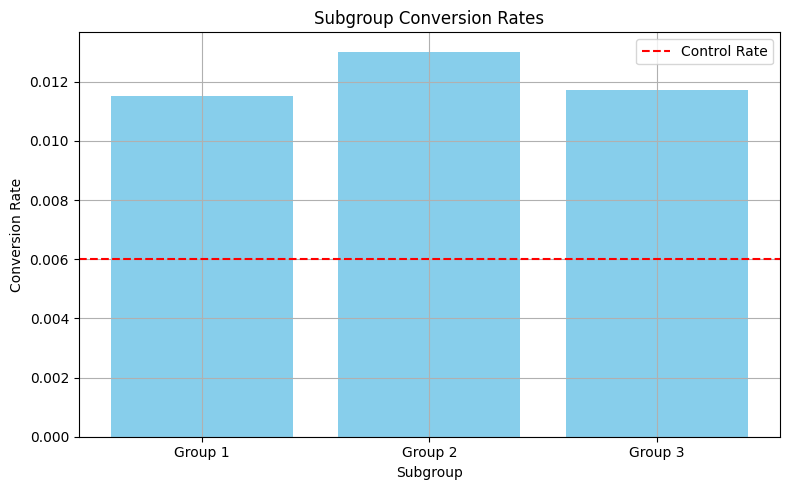

In [113]:
# -------------------------------
# 📦 4. Validation Split into subgroups
# -------------------------------
n_splits = 3            # Number of subgroups to split into
df['subgroup'] = pd.qcut(df['user_id'], n_splits, labels=False)

print(f"\n--- SPLIT INTO {n_splits} GROUPS ---")

subgroup_results = []

for i in range(n_splits):
    group = df[df['subgroup'] == i]
    group_rate = group['converted'].mean()
    group_successes = group['converted'].sum()

    pooled_p = (group_successes + len(group) * baseline_rate) / (2 * len(group))
    se = np.sqrt(pooled_p * (1 - pooled_p) * (2 / len(group)))
    z = (group_rate - baseline_rate) / se
    p = 1- norm.sf(z)

    print(f"Group {i+1}: conv rate = {group_rate:.4%}, z = {z:.2f}, p = {p:.4f}")
    subgroup_results.append(group_rate)

# -------------------------------
# 📈 5. Visualize subgroup conversion rates
# -------------------------------

plt.figure(figsize=(8, 5))
plt.bar(range(n_splits), subgroup_results, color='skyblue')
plt.axhline(y=baseline_rate, color='red', linestyle='--', label='Control Rate')
plt.title('Subgroup Conversion Rates')
plt.xlabel('Subgroup')
plt.ylabel('Conversion Rate')
plt.xticks(range(n_splits), [f"Group {i+1}" for i in range(n_splits)])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()